# Navigation

---

*Jun Zhu, zhujun981661@gmail.com, 08.2020*

In this notebook, I present the solution for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).


### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# !pip install matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('..')
from dqn_agent import DqnAgent
from utilities import check_environment, play, plot_score_history

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
brain_name, state_space, action_space = check_environment(env)
brain_name

Brain name:  BananaBrain
Brain:  Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Number of agents: 1
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37
Number of actions: 4


'BananaBrain'

### 3. Run the environment with random actions

In [4]:
# play(env, brain_name)

### 4. Train an agent with deep-Q network (DQN)

The algorithm first proposed in this [nature paper](https://www.nature.com/articles/nature14236) was implemented. In addition, the following enhancements are included:

1. [Dueling network architecture](https://arxiv.org/abs/1511.06581)
2. [Double Q-learning](https://arxiv.org/abs/1509.06461)

In [5]:
class BananaBrainQNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # state_space = 37
        # action_space = 4
        self._fc1 = nn.Linear(state_space, 128)
        self._fc2 = nn.Linear(128, 64)
                
        # advantange for each action
        self._fc_adv = nn.Linear(64, action_space)
        # value which is independent of the action
        self._fc_value = nn.Linear(64, 1)

    def forward(self, state):
        x = state
        for fc in (self._fc1, self._fc2):
            x = F.relu(fc(x))
            
        v = self._fc_value(x)
        a = self._fc_adv(x)
        return v + (a - a.mean(1, keepdim=True))

In [6]:
actions = np.arange(action_space)
target_score = 13

# initialize the model
model = BananaBrainQNetwork()

# initialize the agent
dqn_agent = DqnAgent(model, actions, 
                     replay_memory_size=int(1e5),  # size of the experience replay buffer
                     double_dqn=True  # use double Q-learning
                    )

# train the agent with given hyperparameters (remove ./dqn_checkpoint.pth to train a new model from scratch)
scores = dqn_agent.train(env,
                         n_episodes=1000,
                         eps_decay_rate=0.98,  # decay rate of epsilon for epsilion-greedy action selection
                         eps_final=0.02,  # minimum (final) value of epsilon
                         target_network_update_frequency=4,  # frequency of updating target network
                         gamma=0.98,  # discount factor
                         learning_rate=5e-4,  # learning rate
                         weight_decay=1e-4,  # L2 regularization
                         batch_size=64,  # mini batch size
                         output_frequency=50,
                         save_frequency=100,
                         target_score=target_score)

Loaded existing model ended at epoch: 442 with averagescore of    13.01
Score of the current model    13.01 is already higher than the target score 13!


Visualize the learning history.

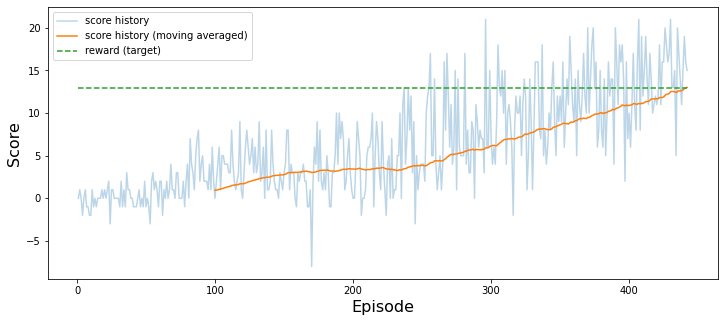

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_score_history(ax, scores, target_score)

In [8]:
play(env, agent=dqn_agent, repeats=10)

Score of play 01:       4.0000
Score of play 02:       3.0000
Score of play 03:       8.0000
Score of play 04:      18.0000
Score of play 05:      24.0000
Score of play 06:      16.0000
Score of play 07:      17.0000
Score of play 08:      21.0000
Score of play 09:       2.0000
Score of play 10:       9.0000


In [9]:
env.close()

### 5. Further improvement

The following algorithms could further improve the performance of the agent:
    
- [Prioritized experience replay](https://arxiv.org/abs/1511.05952)

  It should be noted that there is performance concern over this algorithm.
 
- [Distributional DQN](https://arxiv.org/abs/1707.06887)
- [Noisy network](https://arxiv.org/abs/1706.10295)